In [8]:
import numpy as np
import open3d as o3d
import pyvista as pv

def visualize_overlay(
    mesh,
    pcd,
    mesh_color="red",
    pcd_color="blue",
    mesh_opacity=0.5,
    point_size=5,
):
    """
    Visualize an Open3D TriangleMesh and PointCloud in PyVista:
      - mesh as a surface
      - point cloud as points
    """

    # ---------- Open3D mesh -> PyVista PolyData ----------
    verts = np.asarray(mesh.vertices)
    tris  = np.asarray(mesh.triangles)

    # PyVista expects faces as: [3, i0, i1, i2, 3, j0, j1, j2, ...]
    faces = np.hstack(
        [np.full((tris.shape[0], 1), 3, dtype=np.int64), tris.astype(np.int64)]
    ).ravel()

    pv_mesh = pv.PolyData(verts, faces)

    # ---------- Open3D point cloud -> PyVista PolyData ----------
    points = np.asarray(pcd.points, dtype=np.float32)
    valid_mask = np.all(np.isfinite(points), axis=1)
    points = points[valid_mask]

    pv_pcd = pv.PolyData(points)

    # ---------- PyVista plotting ----------
    plotter = pv.Plotter()
    plotter.add_mesh(
        pv_mesh,
        color=mesh_color,
        opacity=mesh_opacity,
        show_edges=False,
    )
    plotter.add_mesh(
        pv_pcd,
        color=pcd_color,
        point_size=point_size,
        render_points_as_spheres=True,
    )

    
    plotter.export_gltf("scene.gltf")
    plotter.show()
    return plotter

def pointcloud_from_depth(
    depth: np.ndarray,          # (H, W) uint16, encoded "metric_mm" (0.1 mm steps)
    K: np.ndarray,              # (3, 3) intrinsics
    T_cam2world: np.ndarray,    # (4, 4) extrinsic: world <- cam
    *,
    miss_code: int = 0,         # same as in cast(); 0 means "no hit"
    units_to_mm: float = 1.0,   # must match cast(); 1.0 if mesh is in mm
) -> o3d.geometry.PointCloud:
    """
    Construct a point cloud in world coordinates from an encoded Z-depth image.

    Args
    ----
    depth : (H, W) uint16
        Z-depth encoded as "metric_mm":
            stored_value = depth_mesh_units * units_to_mm * 10
        i.e. 0.1 mm per integer if units_to_mm == 1.
        miss_code (default 0) means "no hit".
    K : (3, 3) array
        Camera intrinsic matrix [[fx, 0, cx], [0, fy, cy], [0, 0, 1]].
    T_cam2world : (4, 4) array
        Extrinsic transform that maps homogeneous points from camera frame
        to world frame: X_world = T_cam2world @ X_cam.
    miss_code : int
        Value used for "no hit" pixels in the encoded depth.
    units_to_mm : float
        Factor used in encoding. depth_mesh_units * units_to_mm = mm.

    Returns
    -------
    pcd : open3d.geometry.PointCloud
        Point cloud in world coordinates (same units as mesh).
    """
    assert depth.ndim == 2
    assert K.shape == (3, 3)
    assert T_cam2world.shape == (4, 4)
    print(K)
    H, W = depth.shape
    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]

    # ---- Decode "metric_mm" encoding back to mesh units ----
    # stored_value = depth_mesh * units_to_mm * 10
    # => depth_mesh = stored_value / (units_to_mm * 10)
    depth_u16 = depth.astype(np.float32)
    # mask out miss_code before decoding to avoid treating them as large depths
    valid_mask = depth_u16 != float(miss_code)

    if not np.any(valid_mask):
        return o3d.geometry.PointCloud()

    Z_mesh = np.zeros_like(depth_u16, dtype=np.float32)
    Z_mesh[valid_mask] = depth_u16[valid_mask] / (units_to_mm * 10.0)
    # ---- Pixel grid ----
    u, v = np.meshgrid(np.arange(W), np.arange(H))  # u: x (cols), v: y (rows)

    # Valid depth: non-miss and > 0
    valid = (Z_mesh > 0)
    if not np.any(valid):
        return o3d.geometry.PointCloud()

    u = u[valid].astype(np.float32)
    v = v[valid].astype(np.float32)
    Z = Z_mesh[valid]  # in mesh units (e.g. mm), along camera +Z

    # ---- Backproject into camera coordinates ----
    X = (u - cx) / fx * Z
    Y = (v - cy) / fy * Z
    pts_cam = np.stack([X, Y, Z], axis=1)  # (N, 3)

    # ---- Transform into world coordinates ----
    ones = np.ones((pts_cam.shape[0], 1), dtype=np.float32)
    pts_cam_h = np.hstack([pts_cam, ones])          # (N, 4)
    pts_world_h = (T_cam2world @ pts_cam_h.T).T     # (N, 4)
    pts_world = pts_world_h[:, :3]
    print(pts_world)
    # ---- Build Open3D point cloud ----
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts_world.astype(np.float64))
    return pcd

[Open3D WARNING] Read PLY failed: unable to open file: ../../../data/XrayDepthEstScaling/CT_Dataset/mesh/Pelvic-Ref-026.ply


RPly: Unable to open file


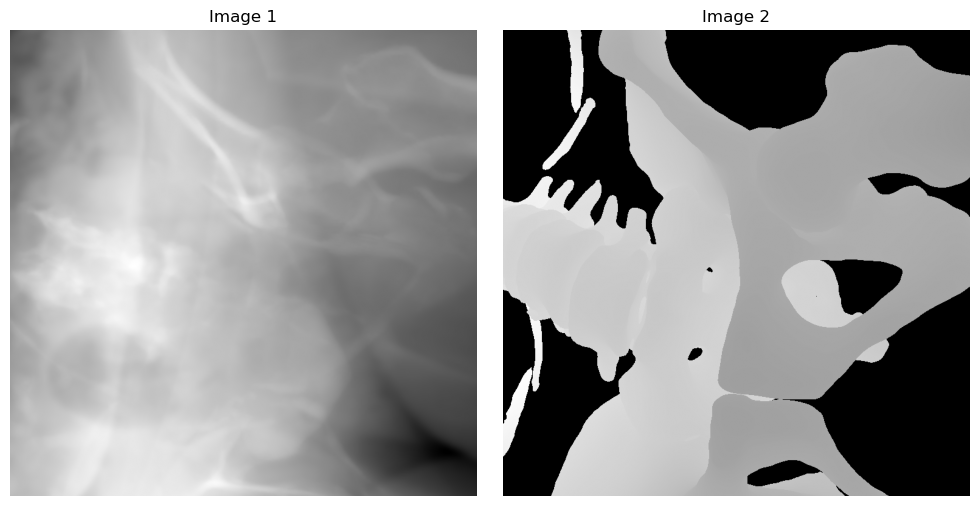

[[2.01897742e+03 0.00000000e+00 3.84000000e+02]
 [0.00000000e+00 2.01897742e+03 3.84000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[132.99235611 139.07066815 356.5403081 ]
 [132.99858687 138.07260145 354.77591838]
 [133.0219072  137.52684056 353.57058994]
 ...
 [-44.72938094 118.0009672   77.54368605]
 [-45.48674019 120.31443406  78.7321634 ]
 [-46.61158159 123.61729046  80.55343901]]


ValueError: Empty meshes cannot be plotted. Input mesh has zero points. To allow plotting empty meshes, set `pv.global_theme.allow_empty_mesh = True`

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import json
import numpy as np
import open3d as o3d

depth = np.array(Image.open('../../../data/XrayDepthEstScaling/depths/Pelvic-Ref-026_0184.tif'))
img = np.array(Image.open('../../../data/XrayDepthEstScaling/images/Pelvic-Ref-026_0184.tif'))
data = json.load(open('../../../data/XrayDepthEstScaling/poses/Pelvic-Ref-026_0184.json'))
camera_intrinsics = np.asarray(data['intrinsic'])
o3d_coordinate = np.asarray(data['extrinsic'])
mesh = o3d.io.read_triangle_mesh("../../../data/XrayDepthEstScaling/CT_Dataset/mesh/Pelvic-Ref-026.ply")

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("Image 1")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(depth, cmap="gray")
plt.title("Image 2")
plt.axis("off")

plt.tight_layout()
plt.show()

pcd = pointcloud_from_depth(
    depth,
    camera_intrinsics,
    o3d_coordinate,
)
visualize_overlay(
    mesh, pcd)